---
### Objetivo:

Uma analise comparativa de pandas X spark (de preferencia no databricks)

### O que fazer:

Pegar 2 datasets um > 50mb e outro menor

Realizar pre-processamento de dados e analise exploratoria dos dados, usando pandas e pyspark

Identificar quando o panda ou pyspark é melhor

### Datasets escolhidos:

https://www.kaggle.com/datasets/swatikhedekar/exploratory-data-analysis-on-netflix-data

Dataset público com informações sobre série e filmes disponiveis na plataforma de streaming Netflix de 2008 a 2021.

Tamanho do dataset = **3.4 mb**


https://www.kaggle.com/datasets/peacehegemony/history-of-music-bnb

Dataset com metadata sobre o catalogo de músicas na livraria britânica em http://explore.bl.uk

Tamanho do dataset = **261 mb**

---

In [1]:
# Importando as bibliotecas que serão utilizadas
import time # para registrar o tempo de execução
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

---
### Trabalhando com o Dataset maior usando SPARK
---

In [2]:
inicio_spark_musica = time.time()

In [3]:
## iniciando o spark

spark = SparkSession.builder.appName("Musicas Data").getOrCreate()

In [4]:
#lendo o arquivo .csv

musicas_spark = spark.read.csv("2detailedrecords.csv", header=True, inferSchema=True)

musicas_spark.show(5)

+------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+-------------------------------+-----------------------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+------------+--------------------+----------+----+----------------+--------------------+
|BL record ID|            Composer|Composer life dates|               Title|Standardised title|        Other titles|         Other names|Publication date (standardised)|Publication date (not standardised)|Country of publication|Place of publication|           Publisher|               Notes|            Contents|  Referenced in| Subject/genre terms|Physical description|Series title|Number within series|      ISBN|ISMN|Publisher number|        BL shelfmark|
+------------+--------------------+-------------------+--------------------+------

In [5]:
#verificando o tamanho do dataset

print((musicas_spark.count(),len(musicas_spark.columns)))

(1045508, 23)


In [6]:
## Alterando os nomes das colunas

colunas = {'BL record ID':'ID da gravação', 'Composer':'Compositor', 'Composer life dates':'Datas de vida do compositor', 'Title':'Titulo',
            'Standardised title':'Titulo padronizado', 'Other titles':'Outros titulos','Other names':'Outros nomes',
            'Publication date (standardised)':'Data de publicação (padronizada)', 'Publication date (not standardised)':'Data de publicação (não padronizada)',
             'Country of publication':'País de publicação', 'Place of publication':'Local de publicação', 'Publisher':'Editora','Notes':'Notas',
             'Contents':'Conteudos extras','Referenced in':'Referencias' ,'Subject/genre terms':'Genero','Physical description':'Descrição física',
             'Series title':'Titulo da série','Number within series':'Número dentro da série',
             'Publisher number':'Número da editora','BL shelfmark':'Marca de Prateleira'
            }

for coluna_antiga, coluna_nova in colunas.items():
    musicas_spark = musicas_spark.withColumnRenamed(coluna_antiga, coluna_nova)

In [7]:
# Verificando os valores ausentes
from pyspark.sql import functions as f

frequencia = musicas_spark.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in musicas_spark.columns])
percentual_na = musicas_spark.select([(f.count(f.when(f.isnull(c), 1))/musicas_spark.count() *100).alias(c) for c in musicas_spark.columns])
percentual_na = percentual_na.select([f.round(c,2).alias(c) for c in percentual_na.columns])
valores_ausentes = frequencia.unionAll(percentual_na)
valores_ausentes.toPandas().transpose().rename(columns={0:'Frequência', 1:'% de NAs'})

,Frequência,% de NAs
ID da gravação,0.0,0.00
Compositor,42059.0,4.02
Datas de vida do compositor,583223.0,55.78
Titulo,22.0,0.00
Titulo padronizado,807218.0,77.21
Outros titulos,1033224.0,98.83
Outros nomes,794108.0,75.95
Data de publicação (padronizada),21494.0,2.06
Data de publicação (não padronizada),15216.0,1.46
País de publicação,334205.0,31.97


In [8]:
# verificando os tipos de dados do df
musicas_spark.printSchema()

root
 |-- ID da gravação: integer (nullable = true)
 |-- Compositor: string (nullable = true)
 |-- Datas de vida do compositor: string (nullable = true)
 |-- Titulo: string (nullable = true)
 |-- Titulo padronizado: string (nullable = true)
 |-- Outros titulos: string (nullable = true)
 |-- Outros nomes: string (nullable = true)
 |-- Data de publicação (padronizada): integer (nullable = true)
 |-- Data de publicação (não padronizada): string (nullable = true)
 |-- País de publicação: string (nullable = true)
 |-- Local de publicação: string (nullable = true)
 |-- Editora: string (nullable = true)
 |-- Notas: string (nullable = true)
 |-- Conteudos extras: string (nullable = true)
 |-- Referencias: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Descrição física: string (nullable = true)
 |-- Titulo da série: string (nullable = true)
 |-- Número dentro da série: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- ISMN: string (nullable = true)
 |-- Núme

In [9]:
# Otimizando o tamanho da variável ano_lancamento

from pyspark.sql.types import IntegerType, StringType

musicas_spark = musicas_spark.withColumn('ID da gravação', musicas_spark['ID da gravação'].cast(IntegerType()))
musicas_spark = musicas_spark.withColumn('Data de publicação (padronizada)', musicas_spark['Data de publicação (padronizada)'].cast(IntegerType()))


In [10]:
musicas_spark.printSchema()

root
 |-- ID da gravação: integer (nullable = true)
 |-- Compositor: string (nullable = true)
 |-- Datas de vida do compositor: string (nullable = true)
 |-- Titulo: string (nullable = true)
 |-- Titulo padronizado: string (nullable = true)
 |-- Outros titulos: string (nullable = true)
 |-- Outros nomes: string (nullable = true)
 |-- Data de publicação (padronizada): integer (nullable = true)
 |-- Data de publicação (não padronizada): string (nullable = true)
 |-- País de publicação: string (nullable = true)
 |-- Local de publicação: string (nullable = true)
 |-- Editora: string (nullable = true)
 |-- Notas: string (nullable = true)
 |-- Conteudos extras: string (nullable = true)
 |-- Referencias: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Descrição física: string (nullable = true)
 |-- Titulo da série: string (nullable = true)
 |-- Número dentro da série: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- ISMN: string (nullable = true)
 |-- Núme

In [11]:
# Agrupando os valores por país de publicação

pais_publicacao = musicas_spark.groupBy('País de publicação').agg(f.count("*").alias("total")).sort(f.desc('total')) 
pais_publicacao.show(3)

+------------------+------+
|País de publicação| total|
+------------------+------+
|           England|416538|
|              null|334205|
|     United States|120741|
+------------------+------+
only showing top 3 rows



In [12]:
# Top 10 paises com mais publicações

top_10_paises = pais_publicacao.limit(10)
top_10_paises = top_10_paises.toPandas()
top_10_paises

,País de publicação,total
0,England,416538
1,None,334205
2,United States,120741
3,Germany (East),46903
4,France,43679
5,Germany,12403
6,Italy,12221
7,Austria,10855
8,Scotland,5712
9,Wales,5308


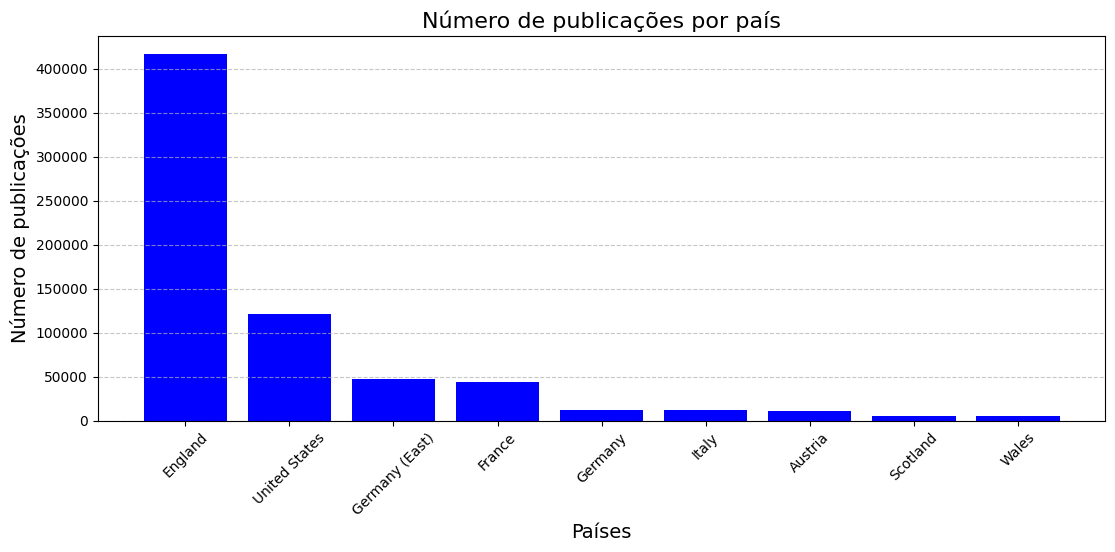

In [13]:
top_10_paises = top_10_paises.dropna().reset_index(drop=True)
plt.figure(figsize=(13,5))
plt.bar(x=top_10_paises['País de publicação'], height=top_10_paises['total'], color='blue')
plt.xlabel('Países', fontsize=14)
plt.ylabel('Número de publicações', fontsize=14)
plt.title('Número de publicações por país', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


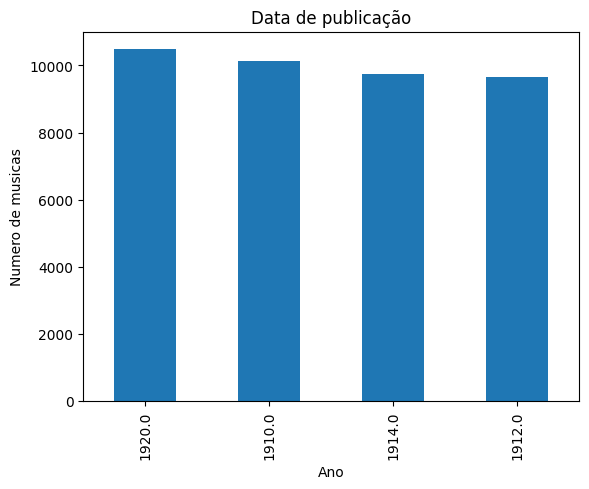

In [14]:
from pyspark.sql.functions import count

# separando o dataset por Data de publicação
data_publicação = musicas_spark.groupBy("Data de publicação (padronizada)").agg(count("*").alias("count"))
top_5 = data_publicação.sort(data_publicação["count"].desc()).limit(5)

# Convertendo o DataFrame Spark em um DataFrame Pandas
pdf = top_5.toPandas().dropna()

# Imprime os grupos resultantes
pdf.plot(kind='bar', x='Data de publicação (padronizada)', y='count', legend=False)

# Adiciona título ao gráfico e rótulos aos eixos
plt.title("Data de publicação")
plt.xlabel("Ano")
plt.ylabel("Numero de musicas")

# Exibe o gráfico
plt.show()

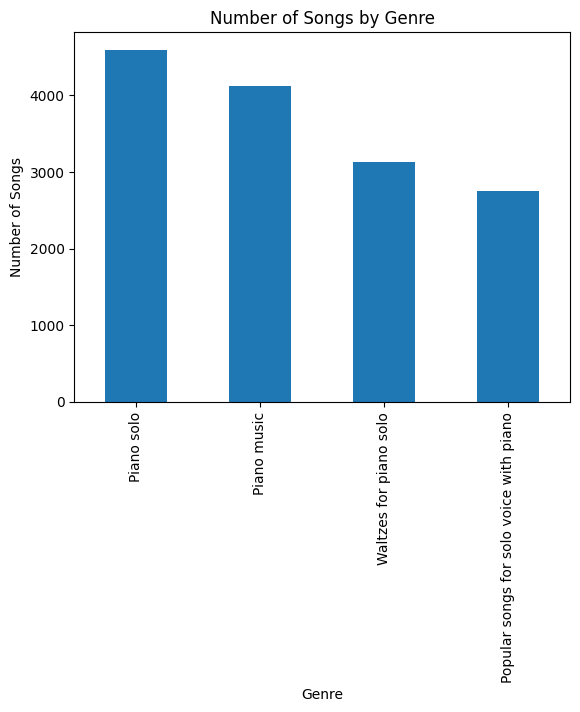

In [15]:

# Conta o número de músicas em cada gênero
count_by_genre = musicas_spark.groupBy("Genero").agg(count("*").alias("count"))

# Seleciona a coluna de título padronizado para contar o número de músicas por gênero
top_5 = count_by_genre.sort(count_by_genre["count"].desc()).limit(5)

# Convertendo o DataFrame Spark em um DataFrame Pandas
pdf = top_5.toPandas().dropna()

# Plota o número de músicas por gênero em um gráfico de barra
pdf.plot(kind='bar', x='Genero', y='count', legend=False)

# Adiciona título ao gráfico e rótulos aos eixos
plt.title("Number of Songs by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Songs")

# Exibe o gráfico
plt.show()

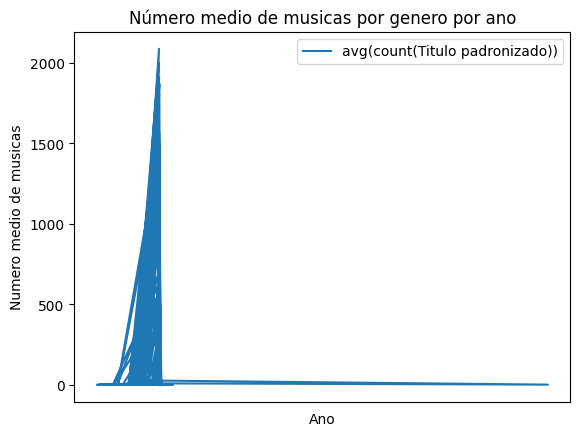

In [16]:
from pyspark.sql import functions as F

# Agrupe as músicas por gênero e ano de publicação
grouped = musicas_spark.groupBy(['Genero', 'Data de publicação (padronizada)'])


# Calcule a média de músicas por gênero e ano de publicação
mean_by_genre_and_year = grouped.agg({"Titulo padronizado": "count"}).groupBy(['Genero', 'Data de publicação (padronizada)']).mean()

mean_by_genre_and_year_pandas = mean_by_genre_and_year.toPandas()

# Plot the mean number of songs by genre and year
mean_by_genre_and_year_pandas.plot(kind='line',x='avg(Data de publicação (padronizada))', y='avg(count(Titulo padronizado))')

# Add title and axis labels to the chart
plt.title("Número medio de musicas por genero por ano")
plt.xlabel("Ano")
plt.ylabel("Numero medio de musicas")
plt.xticks([])

# Display the chart
plt.show()

In [17]:
from pyspark.sql.functions import col, expr

filtrado = musicas_spark.filter((col("Genero").isNotNull()) & (expr("`Data de publicação (padronizada)` > 1980")) & (col("Genero").rlike("rock")))
filtrado = filtrado.toPandas()
filtrado

,ID da gravação,Compositor,Datas de vida do compositor,Titulo,Titulo padronizado,Outros titulos,Outros nomes,Data de publicação (padronizada),Data de publicação (não padronizada),País de publicação,...,Conteudos extras,Referencias,Genero,Descrição física,Titulo da série,Número dentro da série,ISBN,ISMN,Número da editora,Marca de Prateleira
0,5024732,"Dylan, Bob",1941-,The concise Bob Dylan : the music and complete...,Songs. Selections. arranged,None,"Evans, Peter",1997,c1997,England,...,None,None,Folk-rock music ; Popular music--Fake books,"157 pages, 25 cm",None,None,0711957800,None,AM937200,E.1080.a.(1.)
1,5026558,"Anderson, Ian",1947-,The best of - Jethro Tull : [10 songs arranged...,Songs. Selections,None,"Evans, Peter",2000,c2000,England,...,None,None,Popular music--1961-1970 ; Popular music--1971...,"1 score (48 pages), 31 cm",None,None,0711983925,None,AM966350,G.1314.z.(3.)
2,5026997,Corrs (Musical group),None,Play guitar with-- The Corrs : on six of their...,Songs. Selections,None,"Dick, Arthur",1999,c1999,England,...,"Erin Shore (Intro) -- Forgiven, not forgotten ...",None,Popular music--1991-2000 ; Folk-rock music,"1 score (45 pages), 31 cm + 1 sound disc (digi...",None,None,0711978654,None,AM960971,G.1415.ss.(3.)
3,5027326,Corrs (Musical group),None,"Forgiven, not forgotten : [the album arranged ...",None,None,"Jones, Derek",1999,c1999,England,...,Contents: Erin shore (Traditional intro) -- Fo...,None,Folk-rock music ; Folk music--Ireland ; Violin...,"1 score (72 pages), 31 cm",None,None,0711974063,None,AM959123,VH05/8131 ; G.1428.vv.(1.)
4,5027464,Corrs (Musical group),None,The Corrs for violin,Songs. Selections. arranged,None,"Crehan, Dermot",1999,c1999,England,...,None,None,"Folk-rock music ; Violin music, Arranged","31 pages, 31 cm",None,None,0711978719,None,AM961037,G.1428.ee.(3.)
5,5032059,"Simon, Paul",1941-,Simon and Garfunkel hits,Songs. Selections. arranged,None,"Dadi, Marcel",1997,1997,France,...,Contents: April come she will ̂Bookends ̂The b...,None,Folk-rock music ; Guitar music (Folk-rock),"1 score (80 pages), 31 cm",None,None,None,None,EMF 100639,G.1428.bb.(5.)
6,5034913,"Saliers, Emily",1963-,Selections from Indigo Girls : 1200 curfews,Songs. Selections,None,"Ray, Amy ; Whitehill, David ; Anderson, Fred ;...",1998,1998,United States,...,Closer to fine -- Galileo -- Ghost -- I don't ...,None,Folk-rock music ; Guitar music (Folk-rock),"1 score (126 pages), illustrations, 31 cm",Guitar recorded versions,None,079356638X,None,HL00690136,VH05/8218 ; G.1428.ff.(2.)
7,5037086,"Haskell, Gordon",1946-,"Harry's bar : piano, vocal, guitar",None,None,"Harvey, Chris",2002,2002,England,...,Contents: How wonderful you are -- All the tim...,None,Popular music--2001-2010 ; Folk-rock music,"1 score (64 pages), 31 cm",None,None,1843281791,570211791,9672A,G.1431.s.(1.)
8,5038934,Corrs (Musical group),None,The best so far,Songs. Selections,None,None,2000,c2000,England,...,None,None,Folk-rock music,"1 score (80 pages), 31 cm",None,None,0711987564,None,AM969463,G.1431.p.(2.)
9,5247697,"Gold, Ken",None,Who's gonna rock you,Who's gonna rock you. arranged,None,"Ocean, Billy ; Nolans",1982,"1982, c1980",England,...,None,None,Disco rock songs for solo voice with piano,"1 score (4 pages), 31 cm",None,None,None,None,None,G.296.s.(8.)


In [18]:
fim_spark_musica = time.time()

---
### Comparando os resultados
---

In [19]:
# Tempo de execução para o dataframe menor usando:
print('Tempo de execução para o dataframe maior usando:')

#Spark
t4 = fim_spark_musica - inicio_spark_musica
print(f'Usando Spark: {t4}')



Tempo de execução para o dataframe maior usando:
Usando Spark: 53.95509076118469
